# This is a Logistic Regression (Classification) Model for Predicting the Likelihood of Admittance of College Students, Given Their SAT Scores and Genders.

## Importing the relevant libraries

In [1]:
# For this exercise, we will need the following libraries and modules
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # This is done so that all plots will be visualised using the seaborn library by default.
          # The seaborn library produces nicer looking plots than the matplotlib library.

## Loading the raw data

In [2]:
# We will now load the data from the .csv file in the project folder and store it in a data frame called raw_data.
raw_data = pd.read_csv("/Users/GoriPNEUMA/Documents/DataSpell Files/My Portfolio/Logistic Regression Project 1/Predicting Admission Likelihood of College Students/Combined Admittance Data.csv")

# We will explore the top 10 rows of the data frame to see what our data looks like.
raw_data.head(10)

,SAT,Admitted,Gender
0,1363,No,Male
1,1792,Yes,Female
2,1954,Yes,Female
3,1653,No,Male
4,1593,No,Male
5,1755,Yes,Female
6,1775,Yes,Female
7,1887,Yes,Female
8,1893,Yes,Female
9,1580,No,Male


In [3]:
# I will rearrange the data to have the target variable (Admitted) as the first column,
# followed by the predictor variables (SAT and Gender).
raw_data_column_list = list(raw_data) # I list the column titles so I can manually copy and rearrange them.
raw_data_column_list

['SAT', 'Admitted', 'Gender']

In [4]:
# Rearranging the columns manually and storing the rearrangement in "new_columns":
new_columns = ["Admitted",
               "SAT",
               "Gender"]
data = raw_data[new_columns]
data # data with rearranged columns.

,Admitted,SAT,Gender
0,No,1363,Male
1,Yes,1792,Female
2,Yes,1954,Female
3,No,1653,Male
4,No,1593,Male
...,...,...,...
182,No,1726,Male
183,Yes,1876,Female
184,No,1485,Male
185,No,1500,Female


## Preprocessing (Data Cleaning)

### Exploring the descriptive statistics of the variables

In [5]:
data.describe(include='all') # The "include" argument is added so that available descriptive statistics can also be shown for
                                 # categorical (non-numerical) variables.

# Note that categorical variables/features obviously do not have some types of numerical descriptive values
# (like mean, standard deviation, etc.), while numerical variables also do not have the categorical descriptive values,
# hence the NaN in some cells in the table below.

,Admitted,SAT,Gender
count,187,187.000000,187
unique,2,NaN,2
top,Yes,NaN,Male
freq,107,NaN,98
mean,NaN,1697.395722,NaN
std,NaN,183.282477,NaN
min,NaN,1323.000000,NaN
25%,NaN,1549.500000,NaN
50%,NaN,1702.000000,NaN
75%,NaN,1846.000000,NaN


### Determining the variables of interest
##### "Admitted" is our target and we will be using the other two variables: "SAT" and "Gender" as the features in our model.

### Checking for missing values

In [6]:
data.isnull().sum() # Gives us the total number of missing values per variable.

Admitted    0
SAT         0
Gender      0
dtype: int64

###### There are no missing values. Let's proceed.

### Checking for duplicate values

In [7]:
# Check for total number of duplicate values:
data.duplicated().sum()

13

#### We can see that we seem to have 13 duplicate values. However, examining our data realistically, we have just 3 columns and it is very possible to have multiple students with the same SAT scores and genders which will of course most likely lead to the same admission status. I have decided not to remove any perceived duplicate values because of the foregoing.

### Exploring the PDF of the only numerical variable (SAT) to check for outliers

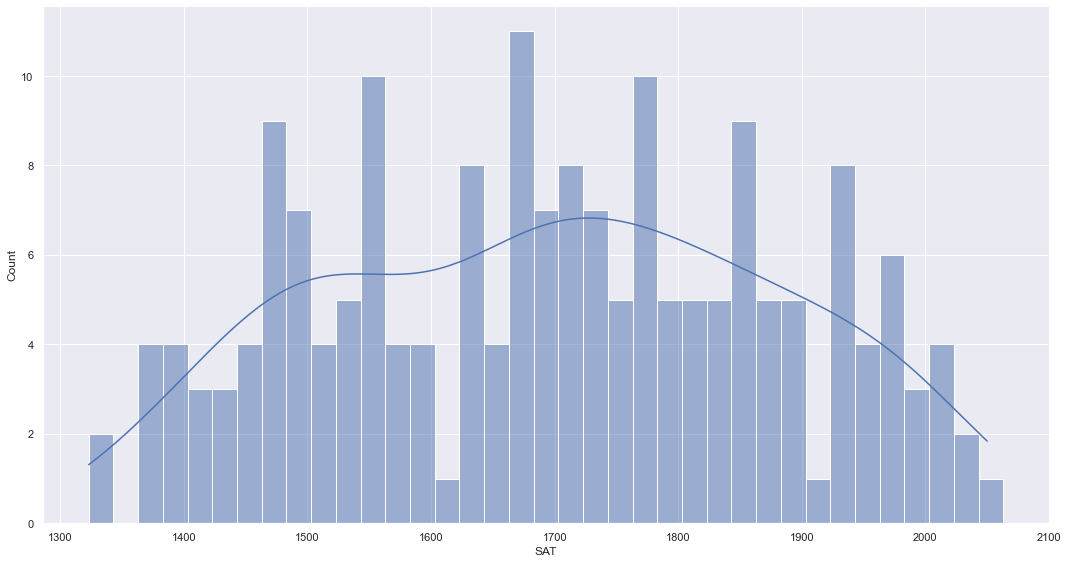

In [8]:
sns.displot(data["SAT"], kde = True, binwidth = 20, height=8, aspect=15/8) # "Admitted" PDF

#### The plot above shows a normal distribution. There aren't any significant outliers that can negatively impact our model. Let's proceed.

#### Before we continue, we should map our binary variables accordingly - Yes and No to 1 and 0 respectively; Female and Male to 1 and 0 respectively.

In [9]:
data["Admitted"] = data["Admitted"].map({"Yes": 1, "No": 0})
data["Gender"] = data["Gender"].map({"Female": 1, "Male": 0})
data

,Admitted,SAT,Gender
0,0,1363,0
1,1,1792,1
2,1,1954,1
3,0,1653,0
4,0,1593,0
...,...,...,...
182,0,1726,0
183,1,1876,1
184,0,1485,0
185,0,1500,1


## Declare the dependent and the independent variables

In [10]:
y = data["Admitted"]
x1 = data[["SAT", "Gender"]]

x = sm.add_constant(x1) # Added constant (necessary step before running regression)

## Checking the Logistic Regression assumptions

### 1. The Response Variable is Binary
##### Response variable only takes on two possible outcomes. Examples: Yes or No, Pass or Fail, Admitted or Not admitted.

#### Our response variable here is "Admitted" and we can confirm from the descriptive statistics that it has only 2 unique values: Yes and No.

### 2. Linearity
##### There must be a linear relationship between each numerical independent variable and the Logit (log of odds of response variable).
One of the most reliable ways to test for this is to use the Box-Tidwell Test.
A statistically significant p-value of what is called the "interaction term" in the Box-Tidwell transformation means that the linearity assumption is violated.
There is a native package in R to run this test, but there isn't one in Python so we will be doing it manually here.
Box-Tidwell test only works for positive values (>0). However, as we have seen earlier that the minimum value for SAT is 1323, we are good to go.

In [11]:
# Logistic Regression with statsmodels - Inclusion of "interaction term" (logit transform) as part of Box-Tidwell test:

data_lt = data.copy()  # lt means "logit transform".

# Define numerical variable(s)
numerical_var = ["SAT"]

# Add logit transform interaction terms (natural log) for numerical variables i.e. SAT * Log(SAT)
for var in numerical_var:
    data_lt[f'{var}:Log_{var}'] = data_lt[var].apply(lambda x: x * np.log(x)) #np.log is natural log

data_lt.head()

,Admitted,SAT,Gender,SAT:Log_SAT
0,0,1363,0,9837.375397
1,1,1792,1,13424.028968
2,1,1954,1,14806.696509
3,0,1653,0,12249.303753
4,0,1593,0,11745.785276


In [12]:
# Keep only columns related to the numerical variable
required_cols = numerical_var + data_lt.columns.tolist()[-len(numerical_var):]
required_cols

['SAT', 'SAT:Log_SAT']

In [13]:
from statsmodels.genmod import families
from statsmodels.genmod.generalized_linear_model import GLM

# Redefine independent variable to include interaction terms
x_lt = data_lt[required_cols]
y_lt = data_lt["Admitted"]

# Add constant
x_lt_constant = sm.add_constant(x_lt, prepend=False)

# Build model and fit the data (using statsmodels' Logit)
logit_results = GLM(y_lt, x_lt_constant, family=families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Admitted   No. Observations:                  187
Model:                            GLM   Df Residuals:                      184
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30.885
Date:                Sat, 15 Oct 2022   Deviance:                       61.770
Time:                        17:48:53   Pearson chi2:                     79.6
No. Iterations:                     9   Pseudo R-squ. (CS):             0.6448
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
SAT            -1.1634      1.516     -0.768      

#### As we can see from the summary above, the p-value for the logit transformed interaction term of SAT (Log_SAT) is not statistically significant as it is more than 0.05. This indicates that our linearity assumption is satisfied/confirmed.
#### As a further means of confirmation, we can do a visual check of the relevant plots...

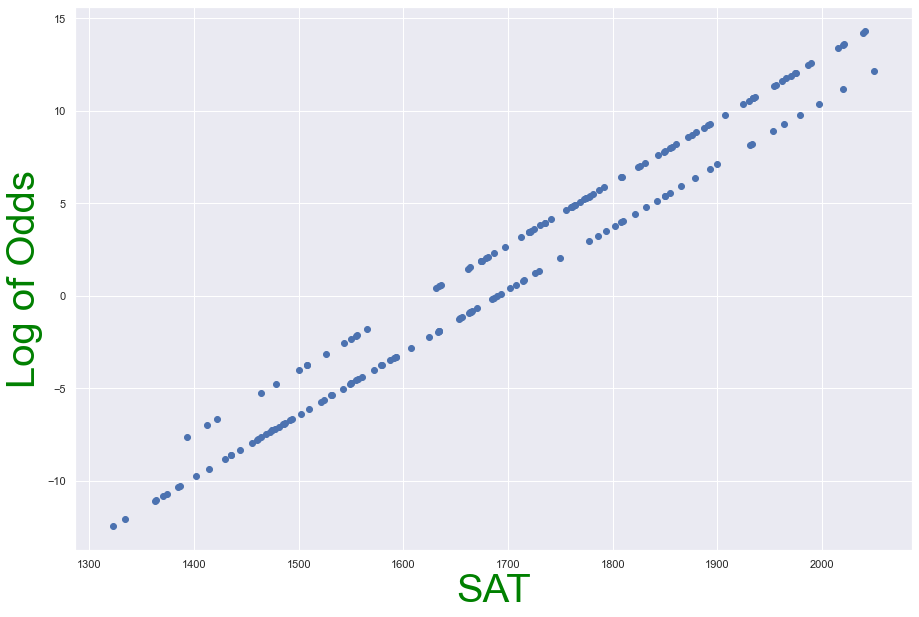

In [14]:
# Re-run logistic regression on original set of x and y variables:
logit_results = GLM(y, x, family=families.Binomial()).fit()
predicted = logit_results.predict(x)

# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize numerical predictor variable vs logit values (SAT)
plt.figure(figsize=(15,10))
plt.scatter(x=x["SAT"].values, y=log_odds)
plt.xlabel("SAT", c="green", size=40)
plt.ylabel("Log of Odds", c="green", size=40)
plt.show()

#### We can confirm from the plot above that there is indeed a linear relationship between the independent numerical variable and the Logit (Log of Odds) of the response variable.

### 3. No Strongly Influential Outliers
##### We have already confirmed this assumption in the Data Preprocessing (Data Cleaning) stage much earlier. We can move on.

### 4. No Multi-collinearity
##### There should be little or no correlation among the independent variables.
We will use the Variance Inflation Factors (VIFs) to determine whether multi-collinearity exists.

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# First add constant:
variables = data[["SAT", "Gender"]]
variables = add_constant(variables)

# Then find VIFs:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

,VIF,Features
0,95.492543,const
1,1.177170,SAT
2,1.177170,Gender


#### Seeing that the VIFs of the predictor variables above are below 5, we can confirm that there is no multi-collinearity among them. Let us now move on.

### 5. Independence of Observations or No Auto-correlation
##### The observations should not come from repeated measurements of the same individual (e.g. before and after measurements) or be related to each other in any way.
The way to confirm this assumption is to do a sort of time-series plot of the residuals and observe whether there is randomness in the plot. If there is, then this assumption is confirmed.

In [16]:
# Setup logistic regression model (using GLM method so that we can retrieve residuals):
logit_model = GLM(y, x, family=families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Admitted   No. Observations:                  187
Model:                            GLM   Df Residuals:                      184
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -25.484
Date:                Sat, 15 Oct 2022   Deviance:                       50.968
Time:                        17:48:53   Pearson chi2:                     63.6
No. Iterations:                     8   Pseudo R-squ. (CS):             0.6647
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -57.1512     11.370     -5.026      0.0

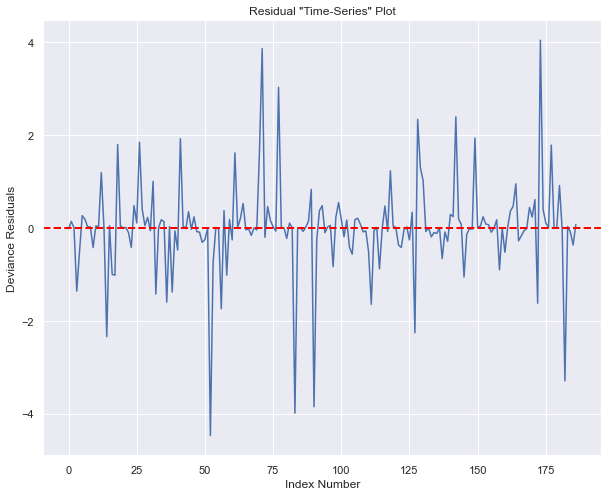

In [17]:
from scipy import stats

# Check residuals' time-series plot:

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, title="Residual \"Time-Series\" Plot",
                     xlabel="Index Number", ylabel="Deviance Residuals")

# ax.plot(x.index.tolist(), stats.zscore(logit_results.resid_pearson))
ax.plot(x.index.tolist(), stats.zscore(logit_results.resid_deviance)) # Similar to code above
plt.axhline(y=0, ls="--", lw=2, color='red');

#### We can observe the randomness in the plot above. This confirms our assumption of independence of observations.

### 6. Sufficiently Large Sample Size
##### The sample size of the data set should be large enough to draw valid conclusions from the fitted logistic regression model.
Estimating the right sample size for logistic regressions is not always so straightforward. Here is a link that contains academic references that specify a generally accepted formula: https://www.medcalc.org/manual/logistic-regression.php

Under the subsection: Sample size considerations, it is suggested to follow the guideline put forth by Peduzzi et al. (1996)...

...if p represents the smaller proportion of positive or negative outcomes, k represents the number of independent variables and N represents the minimum number of observations required, then:

$ N = \frac{10k}{p} $

However, if the result is less than 100, then we should increase our sample size to at least 100 as suggested by Long (1997).

_Note: You can find the full references at the bottom of the linked webpage._

In our case,
$ k = 2\, independent\, variables $ - SAT and Gender
$ p = \frac{80}{187} = 0.43 $ (80 of the 187 outcomes are "No" while 107 are "Yes")

$ Therefore:\\ $
$ N = \frac{10*2}{0.43} = 46.5 $

This should imply that our sample size of 187 is sufficient in our case.

### All Logistic Regression assumptions have now been verified. We can now continue with our model.

In [18]:
# Let's have a quick look at our data set once again before we proceed
data

,Admitted,SAT,Gender
0,0,1363,0
1,1,1792,1
2,1,1954,1
3,0,1653,0
4,0,1593,0
...,...,...,...
182,0,1726,0
183,1,1876,1
184,0,1485,0
185,0,1500,1


## Train Test Split
#### We will now split our data so we can have a subset of it to test the accuracy of our model at the end.

In [19]:
# First declare the inputs and targets:
targets = data["Admitted"]
inputs = data.drop(["Admitted"],axis=1)

In [20]:
# Importing the module for the split:
from sklearn.model_selection import train_test_split

# I will split the data with an 80%:20% split and a specified random state.
# We use the specified random state to ensure we always get the exact same split...
# everytime we run/re-run this part of our code throughout this model building exercise.
# As I do in all my projects, I will use 16 as my random state - my alias has 16 characters :)
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=16)

## Declare the dependent and the independent variables (using train data this time)

In [21]:
y_train

168    0
133    0
11     1
53     0
42     1
      ..
123    0
65     0
69     0
121    0
169    1
Name: Admitted, Length: 149, dtype: int64

In [22]:
x_train

,SAT,Gender
168,1323,0
133,1532,0
11,1880,1
53,1543,1
42,1931,0
...,...,...
123,1430,0
65,1435,0
69,1435,0
121,1572,0


In [23]:
y = y_train
x1 = x_train

## Run the Logistic Regression

In [24]:
x = sm.add_constant(x1) # Added constant (necessary step before running regression)
reg_log = sm.Logit(y,x)
results_log = reg_log.fit()
results_log.summary()

Optimization terminated successfully.
         Current function value: 0.123489
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Admitted   No. Observations:                  149
Model:                          Logit   Df Residuals:                      146
Method:                           MLE   Df Model:                            2
Date:                Sat, 15 Oct 2022   Pseudo R-squ.:                  0.8181
Time:                        17:48:54   Log-Likelihood:                -18.400
converged:                       True   LL-Null:                       -101.17
Covariance Type:            nonrobust   LLR p-value:                 1.129e-36
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -61.6174     13.870     -4.443      0.000     -88.802     -34.433
SAT            0.0364      0.008      4.421      0.000       0.020       0.053
Gender         3.1154      1.005      3.098      0.002       1.145       5.086
==============================================================================

Possibly complete quasi-separation: A fraction 0.23 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

## Interpretations of the Logit Regression Results
#### The variables’ coefficients in the summary table are log (natural log) of odds. To obtain the odds so we can interpret the results, we must find the exponential.

##### Let's start with the interpretation of the SAT variable...

In [25]:
np.exp(0.0364)

1.0370705917730465

The interpretation of the result above is this: Examining two students "A" & "B" of the same gender, the odds of A getting admitted over B increases by 1.037 of B's odds, for every unit increase in A's SAT score over B's.

Let's say we want to check by how much a student's odds of getting admitted will increase if their SAT score increased by 50 points, we would compute this as below:

In [26]:
np.exp(0.0364*50)

6.171858449883554

If Lisa scored 1650 and Jennifer scored 1700, the above result shows that Jennifer's odds of getting admitted increases to 6.17 of Lisa's admittance odds because Jennifer scored 50 points more than Lisa.

##### Now let's do the interpretation of the Gender variable...

In [27]:
np.exp(3.1154)

22.542445528550854

The interpretation of the result above is this: For students of different genders (male - 0 and female - 1) with the same SAT score, the female students' odds of getting admitted is 22.54 times that of the male students'.

So if George and Kate both scored 1660, Kate's odds of getting admitted is 22 times George's odds of getting admitted.

#### Something we can also do is to predict the likelihood/probability of admission of a student given their SAT score and gender.

In [28]:
to_predict = pd.DataFrame({"const": [1], "SAT": [1650], "Gender": [0]}) # Male student with 1650 SAT score.
results_log.predict(to_predict)

0    0.168494
dtype: float64

The above translates thus: The chances of a male student with an SAT score of 1650 getting admitted is 0.168 or 16.8%.

In [29]:
to_predict = pd.DataFrame({"const": [1], "SAT": [1650], "Gender": [1]}) # Female student with 1650 SAT score.
results_log.predict(to_predict)

0    0.820397
dtype: float64

The above translates thus: The chances of a female student with an SAT score of 1650 getting admitted is 0.82 or 82%.

#### We can set a threshold and determine whether a student will be admitted or not (1 or 0) given their gender and SAT score. We will use 11 different scores between 1600 and 1700 (inclusive) for both male and female students as an illustration.

In [30]:
to_predict = pd.DataFrame({"const": [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                           "SAT": [1600,1610,1620,1630,1640,1650,1660,1670,1680,1690,
                                   1700, 1600,1610,1620,1630,1640,1650,1660,1670, 1680, 1690, 1700],
                           "Gender": [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0]}) # Be sure to add
                            # the constant column of 1's to the data frame

probabilities = results_log.predict(to_predict)
threshold = 0.5
predicted = (probabilities > threshold).astype(int) # This implies that any result above the set
                                                    # threshold of 0.5 will be taken as 1 (admitted)
                                                    # and a result below the threshold will be taken
                                                    # as 0 (not admitted).
predicted

0     0
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    1
dtype: int64

#### Let's format our data frame to make it more readable/understandable

In [31]:
summary = pd.DataFrame({"SAT Score": to_predict["SAT"],
                        "Gender": to_predict["Gender"].map({1: "Female", 0: "Male"}),
                        "Admitted?": predicted.map({0: "No", 1: "Yes"})})
summary

,SAT Score,Gender,Admitted?
0,1600,Female,No
1,1610,Female,Yes
2,1620,Female,Yes
3,1630,Female,Yes
4,1640,Female,Yes
5,1650,Female,Yes
6,1660,Female,Yes
7,1670,Female,Yes
8,1680,Female,Yes
9,1690,Female,Yes


#### We can see that only one female student who scored 1600 was not admitted while other female students who scored between 1610 and 1700 were all admitted. On the other hand, only one male student who scored 1700 was admitted while other male students who scored between 1600 and 1690 were not admitted.

#### This result seems to make sense if we consider these students to be prospective STEM (Science, Technology, Engineering and Mathematics) college students. As the representation of females in these fields is usually lower than males, this college has decided to encourage enrollment from female students by lowering the bar for admission for them. The opposite is also likely to occur for course admissions in the Arts and Social Sciences where male representation is usually lower.

## Calculating the Accuracy of Our Model

#### What we will do is use our model to predict the outcomes (admitted or not admitted) and compare the results to the actual outcomes from the data set.

In [32]:
results_log.predict() # Predicted outcomes from our model.

array([1.38277337e-06, 2.76277734e-03, 9.99949101e-01, 8.52367125e-02,
       9.99820549e-01, 9.98751407e-01, 9.99999069e-01, 2.45372838e-01,
       9.99997771e-01, 9.74465591e-01, 5.30399331e-03, 9.99945966e-01,
       1.68276409e-04, 9.99980938e-01, 3.97589912e-04, 7.62831750e-01,
       9.99992861e-01, 9.96594459e-01, 1.41847496e-05, 8.83993631e-06,
       6.94894706e-04, 9.16220919e-01, 9.96011898e-01, 6.83159248e-03,
       9.99919382e-01, 3.74533860e-04, 7.18497019e-01, 2.09311845e-04,
       5.23589412e-03, 9.98023770e-01, 2.54215746e-02, 6.14426087e-06,
       9.95449372e-01, 9.95220184e-01, 6.75189399e-01, 1.31894284e-05,
       5.11548949e-03, 9.99997422e-01, 9.99804486e-01, 9.99833139e-01,
       6.35527074e-03, 9.96290703e-01, 1.85337381e-03, 5.73277091e-01,
       9.99445982e-01, 5.00980331e-04, 7.89313939e-03, 3.48262223e-04,
       2.79993294e-04, 1.50819195e-02, 9.96594459e-01, 9.46087222e-01,
       9.99998334e-01, 9.98811478e-01, 9.99882500e-01, 7.64288618e-06,
      

In [33]:
np.array(y_train) # Actual outcomes from our data set.

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1])

#### To easily compare the two arrays above, we will summarise them in a "Prediction Table":

In [34]:
results_log.pred_table() # Prediction Table also known as "Confusion Matrix".

array([[59.,  3.],
       [ 4., 83.]])

#### To easily interpret the matrix above, we can reformat it thus:

In [35]:
cm_df = pd.DataFrame(results_log.pred_table()) # cm_df = confusion matrix data frame
cm_df.columns = ['Predicted 0','Predicted 1']
cm_df = cm_df.rename(index={0: 'Actually 0',1:'Actually 1'})
cm_df

,Predicted 0,Predicted 1
Actually 0,59.0,3.0
Actually 1,4.0,83.0


#### This is how the reformatted matrix above is interpreted:

##### For 59 observations, our model predicted 0 (not admitted) and the actual outcomes were 0.
##### For 83 observations, our model predicted 1 (admitted) and the actual outcomes were 1.

#### However,

##### For 3 observations, our model predicted 1 (admitted) and the actual outcomes were 0 (not admitted).
##### For 4 observations, our model predicted 0 (not admitted) and the actual outcomes were 1 (admitted).

#### The foregoing two statements are the instances our model predicted wrongly. They are quite few compared to the correct predictions. We can calculate the accuracy of our model thus:

In [36]:
cm = np.array(cm_df) # First create an array so it is easier to calculate the accuracy.

# Calculate the accuracy of the model
accuracy_train = (cm[0,0]+cm[1,1])/cm.sum() # accuracy_train = accuracy of our model based on train data.
accuracy_train

0.9530201342281879

#### The above shows our model is 95.3% accurate.

##### In case you don't understand the previous code block where we calculated the accuracy, what we have done is this:

Our model predicted correctly in 59+83 (142) cases but predicted wrongly in 3+4 (7) cases.
Since we have a total of 149 cases, we can calculate our accuracy thus:

$ \frac{142}{149} * 100\% = 95.302\%$

## Testing Our Model

#### We should remember we did an 80%-20% train-test-split of our data set earlier. We will now use the test portion of the data set (which our model has never seen) to test and verify the accuracy of our model so we can be sure our model has not over-fitted on the train data thereby giving us a misleading result of 95% accuracy.

In [37]:
# Actual outcomes (admitted or not admitted) from the test data:
y_test

124    1
113    1
161    1
153    1
117    0
87     1
177    1
48     0
45     0
52     0
105    1
0      0
104    0
155    0
100    1
71     1
61     1
7      1
32     0
172    0
9      0
185    0
148    0
174    1
138    0
176    1
126    1
56     0
59     1
137    0
81     1
29     1
135    0
109    0
20     1
143    1
51     1
181    0
Name: Admitted, dtype: int64

In [38]:
# Test input data:
x_test

,SAT,Gender
124,1891,1
113,1934,1
161,1934,1
153,1893,0
117,1475,0
87,1979,0
177,1708,0
48,1486,0
45,1414,0
52,1697,1


In [39]:
# Don't forget to add constants to the test input data:
x_test = sm.add_constant(x_test)
x_test

,const,SAT,Gender
124,1.0,1891,1
113,1.0,1934,1
161,1.0,1934,1
153,1.0,1893,0
117,1.0,1475,0
87,1.0,1979,0
177,1.0,1708,0
48,1.0,1486,0
45,1.0,1414,0
52,1.0,1697,1


#### We will now write a function to determine our confusion matrix for our test data
##### I have tried to furnish the following code cell with explanatory comments to explain what is going on.

In [40]:
def confusion_matrix(test_input_data,actual_outcomes,model):

        # Confusion matrix

        # Parameters
        # ----------
        # test_input_data: A data frame or array
            # This is the data frame that contains our test input data only.
            # The order of the variables in this data frame is very important!
            # The variable order should be identical to that of the train input data. e.g. const, var1, var2, etc.
        # actual_outcomes: A data frame or array
            # These are the actual outcomes (admitted or not admitted) from the test_data.
            # In the case of a logistic regression, it should be a single column with 0s and 1s

        # model: a LogitResults object
            # this is the variable where we have our fitted model
            # e.g. results_log in this project.
        # ----------

        #Predict the values using the Logit model
        predicted_outcomes = model.predict(test_input_data)

        # Specify the bins
        bins=np.array([0,0.5,1])

        # Create a histogram, where if values are between 0 and 0.5 they will be considered 0
        # ...but if they are between 0.5 and 1, they will be considered 1
        cm_2 = np.histogram2d(actual_outcomes, predicted_outcomes, bins=bins)[0]

        # Return the confusion matrix
        return cm_2

In [41]:
# Create a confusion matrix with the test data
cm_2 = confusion_matrix(x_test,y_test,results_log)
cm_2

array([[17.,  1.],
       [ 1., 19.]])

#### Let's reformat as we did before for our train data, to aid understanding:

In [42]:
cm_2_df = pd.DataFrame(cm_2) # cm_2_df = 2nd confusion matrix data frame (1st was for train data).
cm_2_df.columns = ['Predicted 0','Predicted 1']
cm_2_df = cm_2_df.rename(index={0: 'Actually 0',1:'Actually 1'})
cm_2_df

,Predicted 0,Predicted 1
Actually 0,17.0,1.0
Actually 1,1.0,19.0


#### We can now calculate the accuracy of our model performance on the test data:

In [43]:
cm_2_df = np.array(cm_2_df) # First create an array so it is easier to calculate the accuracy.
accuracy_test = (cm_2_df[0,0]+cm_2_df[1,1])/cm_2_df.sum()
accuracy_test

0.9473684210526315

#### We can see from the result above that our model's performance on the test data is 94.7%. This is not too far from the result of the train data (95.3%) which shows that there was negligible over-fitting and our model performs quite well overall.

## One Extra Note

#### There is something called Mis-classification Rate. This is just like the opposite of Accuracy. It shows the level of inaccuracy of our model so obviously the aim is to minimise this figure.

In [44]:
# Calculating the mis-classification rate:
# Note that Accuracy + Mis-classification rate = 1 = 100%
print ('Mis-classification rate: '+str((1+1)/(17+19+1+1)))

Mis-classification rate: 0.05263157894736842


#### So the Mis-classification Rate is 5%